In [2]:
import numpy as np 
import pandas as pd # 시리즈, 데이터프레임 포맷 데이터 처리를 위한 라이브러리
import warnings; warnings.filterwarnings(action='ignore') # 경고 메시지 무시
import matplotlib.pyplot as plt # 데이터 시각화 라이브러리
import pickle # 객체 입출력을 위한 라이브러리

from sklearn.model_selection import train_test_split # 훈련 데이터, 테스트 데이터 분리
from sklearn.preprocessing import StandardScaler # 정규화

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV


# LightGBM 임포트
from lightgbm import LGBMClassifier # LightGBM 불러오기 (LightGBM의 파이썬 패키지인 lightgbm에서 LGBMclassifier import)
import lightgbm as lgb
from pandas.core.common import random_state


import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd


# 모델 평가를 위한 metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve, plot_confusion_matrix
from sklearn.metrics import roc_auc_score

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [3]:
from google.colab import drive # gdrive 연동
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Disease 

df2 = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/aiffel_data/Hackerton_2/data_over_sampling.csv', encoding='cp949') # upsampling 안된 것!
df2

,SEX,BTH_G,SBP,DBP,FBS,BMI,Dis
0,1,1,116,78,94,16.6,0
1,1,1,100,60,79,22.3,0
2,1,1,100,60,87,21.9,0
3,1,1,111,70,72,20.2,0
4,1,1,120,80,98,20.0,0
...,...,...,...,...,...,...,...
1481319,0,25,120,80,78,27.9,1
1481320,0,27,150,74,133,32.0,1
1481321,1,25,120,70,118,26.9,1
1481322,0,20,136,68,93,21.5,1


In [5]:
df2.notnull().sum()

SEX      1481324
BTH_G    1481324
SBP      1481324
DBP      1481324
FBS      1481324
BMI      1481324
Dis      1481324
dtype: int64

In [6]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1481324 entries, 0 to 1481323
Data columns (total 7 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   SEX     1481324 non-null  int64  
 1   BTH_G   1481324 non-null  int64  
 2   SBP     1481324 non-null  int64  
 3   DBP     1481324 non-null  int64  
 4   FBS     1481324 non-null  int64  
 5   BMI     1481324 non-null  float64
 6   Dis     1481324 non-null  int64  
dtypes: float64(1), int64(6)
memory usage: 79.1 MB


In [7]:
# feature와 target 분리(설명변수 및 목표변수 분리)
x = df2.drop(['Dis'], axis=1) # df[df.columns.difference(['target'])]
y = np.array(df2['Dis']) # y = df['target']

# Feature Scaling (standardScaler)
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x)
x_test = sc.transform(x)

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25, random_state=42) # 기본 0.25
# x_test,x_val,y_test,y_val=train_test_split(x,y,test_size=0.1, random_state=42)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
# print(x_val.shape)
# print(y_val.shape)

(1110993, 6)
(1110993,)
(370331, 6)
(370331,)


lightgbm 하이퍼 파라미터 튜닝


In [8]:
def algorithm_pipeline(x_train, x_test, y_train, y_test, 
                       model, param_grid, cv=10, scoring_fit='neg_mean_squared_error',
                       do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2
    )
    fitted_model = gs.fit(x_train, y_train)
    
    if do_probabilities:
      pred = fitted_model.predict_proba(x_test)
    else:
      pred = fitted_model.predict(x_test)
    
    return fitted_model, pred

In [8]:
model = lgb.LGBMClassifier()

param_grid = {
    'n_estimators': [400, 700, 1000], # 계속 나무를 반복하며 부스팅을 하는데 몇번을 할것인가이다. lgb는 기본값이 100이라 너무 적은편이다. 1000이상정도는 해주도록 한다. 너무나도 많이하면 당연히 오버피팅이 된다.
    'colsample_bytree': [0.7, 0.8], # 컬럼에 대한 샘플링을 통해 각각의 다양성을 높인다.
    'max_depth': [15,20,25], # 1로 설정하면 제한없이 분기한다. 많은 feature가 있는 경우 더더욱 높게 설정하며, 파라미터 설정시 제일 먼저 설정
    # 'num_leaves': [50, 100, 200],
    # 'reg_alpha': [1.1, 1.2, 1.3],
    # 'reg_lambda': [1.1, 1.2, 1.3],
    # 'min_split_gain': [0.3, 0.4],
    'subsample': [0.7, 0.8, 0.9], # Row sampling, 즉 데이터를 일부 발췌해서 다양성을 높이는 방법으로 쓴다. 민감한 옵션이므로, Column sampling과 잘 섞어서 쓴다.
    # 'subsample_freq': [20]
}

model, pred = algorithm_pipeline(x_train, x_test, y_train, y_test, model, 
                                 param_grid, cv=5, scoring_fit='accuracy')

print("최고 평균 정확도 : {0:.4f}".format(model.best_score_))
print("최고의 파라미터 :", model.best_params_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


KeyboardInterrupt: ignored

예전 동일한 데이터셋으로 하이퍼 파라미터 그리드 서치를 한 후의 결과

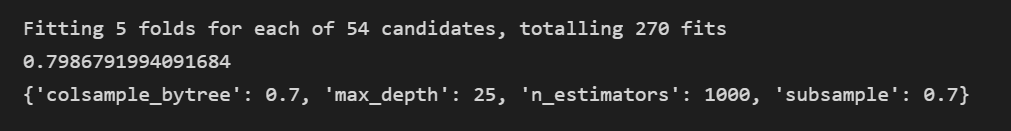

In [ ]:
# 참고할 파라미터 튜닝

In [ ]:
# hyper_params = {
#     'n_estimators': 100, # 400 # 사이킷런 래퍼 (파이썬 래퍼에서는 num_iterations) n_estimators 학습할때 사용하는 트리의 갯수. num_iteration은 prediction할때 사용하는 트리의 갯수
#     'num_iterations': 28000, # 파이썬 래퍼에서 import를 했으므로 이게 사용된다.
#     'task': 'train',
#     'boosting_type': 'gbdt',
#     'objective': 'multiclass', # 이진 분류일때는 binary, 다중 분류일때는 multiclass
#     'metric': 'multi_logloss', # ['auc_mu', 
#     'learning_rate': 0.1, # 0.005
#     'feature_fraction': 1.0, # 0.9
#     'bagging_fraction': 1.0, # 0.7
#     'bagging_freq': 10,
#     # 'verbose': 0,
#     'max_depth': 8, # 20
#     # 'min_data' : 20
#     # 'min_child_samples' =60
#     'num_leaves': 128, # 31
#     'max_bin': 512, # 255
#     # 'device' : 'gpu'
# }

In [15]:
# 하이퍼 파라미터 튜닝값 넣기!
# 'colsample_bytree': 0.7, 'max_depth': 25, 'n_estimators': 1000, 'subsample': 0.7

hyper_params = {
    # 'n_estimators' : 100, # 사이킷런 래퍼에서 사용 아래 num_iterations과 동일함. n_estimators를 파이썬 래페에서 num_iterations을 사용해도 된다.
    'num_iterations' : 20000, # 파이썬 래퍼에서 import를 했으므로 이게 사용된다.
    'subsample' : 0.7, 
    'max_depth' : 25,
    'colsample_bytree' : 0.7 
}

In [16]:
lgbm_wrapper = LGBMClassifier(**hyper_params)

# LightGBM도 XGBoost와 동일하게 조기 중단 수행 가능.
evals = [(x_train, y_train), (x_test, y_test)]
lgbm_wrapper.fit(x_train, y_train, early_stopping_rounds=50, eval_metric="logloss", eval_set=evals, verbose=True)
preds = lgbm_wrapper.predict(x_test)
pred_proba = lgbm_wrapper.predict_proba(x_test)[:, 1]

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[7575]	training's binary_logloss: 0.365053	training's binary_logloss: 0.365053	valid_1's binary_logloss: 0.406988	valid_1's binary_logloss: 0.406988
[7576]	training's binary_logloss: 0.365051	training's binary_logloss: 0.365051	valid_1's binary_logloss: 0.406987	valid_1's binary_logloss: 0.406987
[7577]	training's binary_logloss: 0.365048	training's binary_logloss: 0.365048	valid_1's binary_logloss: 0.406985	valid_1's binary_logloss: 0.406985
[7578]	training's binary_logloss: 0.365046	training's binary_logloss: 0.365046	valid_1's binary_logloss: 0.406983	valid_1's binary_logloss: 0.406983
[7579]	training's binary_logloss: 0.365036	training's binary_logloss: 0.365036	valid_1's binary_logloss: 0.406973	valid_1's binary_logloss: 0.406973
[7580]	training's binary_logloss: 0.365034	training's binary_logloss: 0.365034	valid_1's binary_logloss: 0.406972	valid_1's binary_logloss: 0.406972
[7581]	training's binary_logloss: 0.365033	training's binary_logloss: 

In [17]:
lgb_pred = lgbm_wrapper.predict(x_test)

In [18]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(lgb_pred, y_test)
print('LightGBM accuracy score: {0:0.4f}'.format(accuracy_score(y_test, lgb_pred)))

LightGBM accuracy score: 0.8162


In [19]:
# Training set score
y_pred_train = lgbm_wrapper.predict(x_train)
print('LightGBM Model training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))
# Testing set score
accuracy = accuracy_score(lgb_pred, y_test)
print('LightGBM Model testing-set accuracy score: {0:0.4f}'.format(accuracy_score(y_test, lgb_pred)))

LightGBM Model training-set accuracy score: 0.8440
LightGBM Model testing-set accuracy score: 0.8162


In [20]:
# view confusion-matrix
# Print the Confusion Matrix and slice it into four pieces

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, lgb_pred)
print('Confusion matrix\n\n', cm)
# print('\nTrue Positives(TP) = ', cm[0,0])
# print('\nTrue Negatives(TN) = ', cm[1,1])
# print('\nFalse Positives(FP) = ', cm[0,1])
# print('\nFalse Negatives(FN) = ', cm[1,0])


Confusion matrix

 [[143103  41651]
 [ 26416 159161]]


In [21]:
from sklearn.metrics import classification_report
print(classification_report(y_test, lgb_pred))

              precision    recall  f1-score   support

           0       0.84      0.77      0.81    184754
           1       0.79      0.86      0.82    185577

    accuracy                           0.82    370331
   macro avg       0.82      0.82      0.82    370331
weighted avg       0.82      0.82      0.82    370331



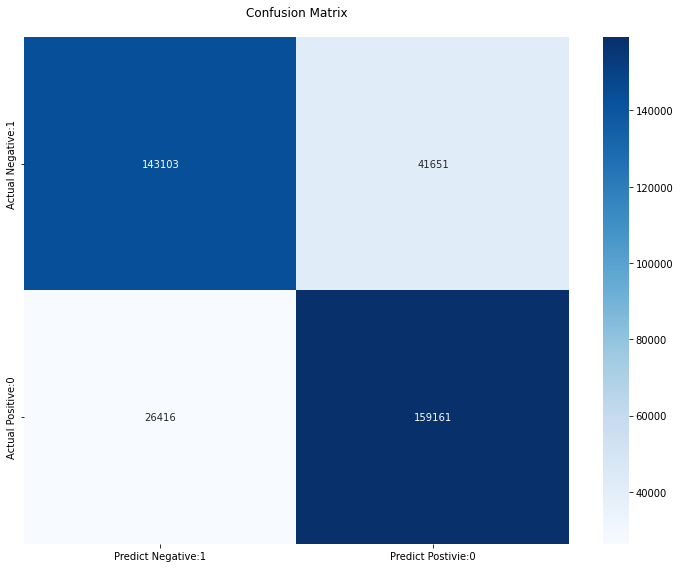

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,8))
cm = confusion_matrix(y_test, lgb_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['Predict Negative:1', 'Predict Postivie:0'],
                                 index=['Actual Negative:1', 'Actual Positive:0'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix\n")
plt.tight_layout()

In [27]:
# Precision-Recall Curve Plot 그리기
def precision_recall_curve_plot(y_test, pred_proba):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba)
    
    # x축을 threshold, y축을 정밀도, 재현율로 그래프 그리기
    plt.figure(figsize=(8, 6))
    thresholds_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[:thresholds_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[:thresholds_boundary], linestyle=':', label='recall')
    
    # threshold의 값 X축의 scale을 0.1 단위로 변경
    stard, end = plt.xlim()
    plt.xticks(np.round(np.arange(stard, end, 0.1), 2))
    
    plt.xlim()
    plt.xlabel('thresholds')
    plt.ylabel('precision & recall value')
    plt.legend()
    plt.grid()

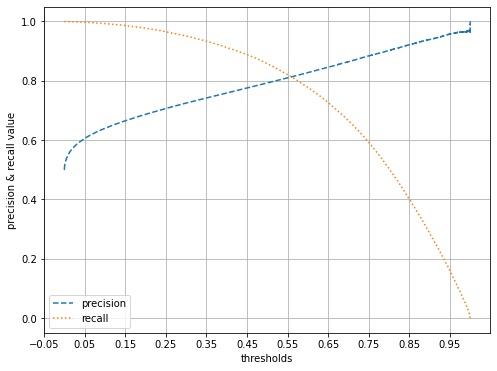

In [28]:
# 임계값별로 정밀도-재현율 출력
pred_proba = lgbm_wrapper.predict_proba(x_test)[:, 1]
precision_recall_curve_plot(y_test, pred_proba)

In [30]:
predict_y = lgbm_wrapper.predict(x_test)


from sklearn.metrics import roc_curve
fprs, tprs, thresholds = roc_curve(y_test, predict_y)
thr_index = np.arange(1, thresholds.shape[0], 5)

print('샘플 추출을 위한 임곗값 배열의 index:', thr_index)
print('샘플 index로 추출한 임곗값: ', np.round(thresholds[thr_index], 2))

# 5 step 단위로 추출된 임계값에 따른 FPR, TPR 값
print('샘플 임곗값별 FPR: ', np.round(fprs[thr_index], 3))
print('샘플 임곗값별 TPR: ', np.round(tprs[thr_index], 3))

샘플 추출을 위한 임곗값 배열의 index: [1]
샘플 index로 추출한 임곗값:  [1]
샘플 임곗값별 FPR:  [0.225]
샘플 임곗값별 TPR:  [0.858]


In [33]:
from sklearn.metrics import roc_auc_score
pred_proba = lgbm_wrapper.predict_proba(x_test)[:, 1]
roc_score = roc_auc_score(y_test, pred_proba)
print('ROC AUC 값: {0:.4f}'.format(roc_score))

ROC AUC 값: 0.8983


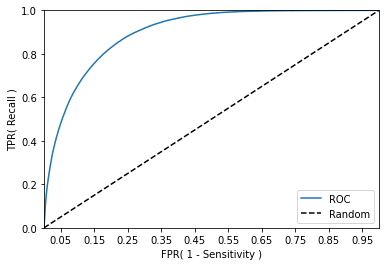

In [36]:
def roc_curve_plot(y_test , pred_proba_c1):
    # 임곗값에 따른 FPR, TPR 값을 반환 받음. 
    fprs , tprs , thresholds = roc_curve(y_test ,pred_proba_c1)

    # ROC Curve를 plot 곡선으로 그림. 
    plt.plot(fprs , tprs, label='ROC')
    # 가운데 대각선 직선을 그림. 
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    
    # FPR X 축의 Scale을 0.1 단위로 변경, X,Y 축명 설정등   
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel('FPR( 1 - Sensitivity )'); plt.ylabel('TPR( Recall )')
    plt.legend()
    plt.show()
    
roc_curve_plot(y_test, lgbm_wrapper.predict_proba(x_test)[:, 1] )

# XGBoost

In [9]:
import xgboost as xgb


In [10]:
# feature와 target 분리(설명변수 및 목표변수 분리)
x = df2.drop(['Dis'], axis=1) # df[df.columns.difference(['target'])]
y = np.array(df2['Dis']) # y = df['target']

# Feature Scaling (standardScaler)
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x)
x_test = sc.transform(x)

# train, test split 분리
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25, random_state=42) # 기본 0.25
# x_test,x_val,y_test,y_val=train_test_split(x,y,test_size=0.1, random_state=42)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
# print(x_val.shape)
# print(y_val.shape)                                                                                  

(1110993, 6)
(1110993,)
(370331, 6)
(370331,)


In [13]:
# 넘파이 형태의 학습 데이터 세트와 테스트 데이터를 DMatrix로 변환하는 예제
dtrain = xgb.DMatrix(data=x_train, label = y_train)
dtest = xgb.DMatrix(data=x_test, label= y_test)

In [12]:
model = xgb.XGBClassifier()

xgb_param_grid = {
    # 'n_estimators' : [100, 200, 400, 600], # n_estimators는 최대한 많은 값을 준다. early stopping을 줘서 최적의 loss값 찾기
    'learning_rate' : [0.01, 0.05, 0.1, 0.15, 0.2],
    'max_depth' : [4, 6, 8, 10, 12],
    'colsample_bytree' : [0.7, 0.8],
    'subsample' : [0.7, 0.8, 0.9]
}

model, pred = algorithm_pipeline(x_train, x_test, y_train, y_test, model,
                                 xgb_param_grid, cv=5, scoring_fit='accuracy')

print("최고 평균 정확도 : {0:.4f}".format(model.best_score_))
print("최고의 파라미터 :", model.best_params_)

# 2시간 20분 소요됨 

Fitting 5 folds for each of 150 candidates, totalling 750 fits


KeyboardInterrupt: ignored

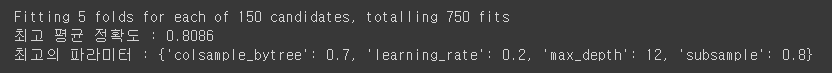

In [14]:
# max_depth = 3, 학습률은 0.1, 예제가 이진분류이므로 목적함수(objective)는 binary:logistic(이진 로지스틱)
# 오류함수의 평가성능지표는 logloss
# 조기중단을 위한 최소 반복횟수는 50

params = {'max_depth' : 12,
         'learning_rate' : 0.2, 
         'objective' : 'binary:logistic',
         'subsample' : 0.8,
         'eval_metric' : 'logloss', # 조기 중단을 위해서 eval_set과 set로 함께 설정 되어야 한다.
         'early_stoppings' : 50,
          'colsample_bytree' : 0.7}

num_rounds = 5000 # n_estimators와 같음

In [15]:
# train 데이터 세트는 'train', evaluation(test) 데이터 세트는 'eval' 로 명기
wlist = [(dtrain, 'train'), (dtest,'eval')]
# 하이퍼 파라미터와 early stopping 파라미터를 train() 함수의 파라미터로 전달
xgb_model = xgb.train(params = params, dtrain=dtrain, num_boost_round=num_rounds, evals=wlist)

[0]	train-logloss:0.624015	eval-logloss:0.625427
[1]	train-logloss:0.566633	eval-logloss:0.569568
[2]	train-logloss:0.529374	eval-logloss:0.533526
[3]	train-logloss:0.500602	eval-logloss:0.505846
[4]	train-logloss:0.479656	eval-logloss:0.485999
[5]	train-logloss:0.470154	eval-logloss:0.477432
[6]	train-logloss:0.463229	eval-logloss:0.471367
[7]	train-logloss:0.450298	eval-logloss:0.459641
[8]	train-logloss:0.440833	eval-logloss:0.4513
[9]	train-logloss:0.436971	eval-logloss:0.448352
[10]	train-logloss:0.430392	eval-logloss:0.442636
[11]	train-logloss:0.42786	eval-logloss:0.440899
[12]	train-logloss:0.423132	eval-logloss:0.436971
[13]	train-logloss:0.421168	eval-logloss:0.435803
[14]	train-logloss:0.417412	eval-logloss:0.432898
[15]	train-logloss:0.415947	eval-logloss:0.432084
[16]	train-logloss:0.413413	eval-logloss:0.430156
[17]	train-logloss:0.411022	eval-logloss:0.428436
[18]	train-logloss:0.409013	eval-logloss:0.427073
[19]	train-logloss:0.407611	eval-logloss:0.426403
[20]	train-lo

In [16]:
pred_probs = xgb_model.predict(dtest)
print('predict() 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10], 3))

# 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 결정해 리스트 객체인 preds에 저장
preds = [ 1 if x > 0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시: ', preds[:10])

predict() 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨
[0.98  1.    0.997 0.022 0.001 0.    0.981 0.965 0.993 0.998]
예측값 10개만 표시:  [1, 1, 1, 0, 0, 0, 1, 1, 1, 1]


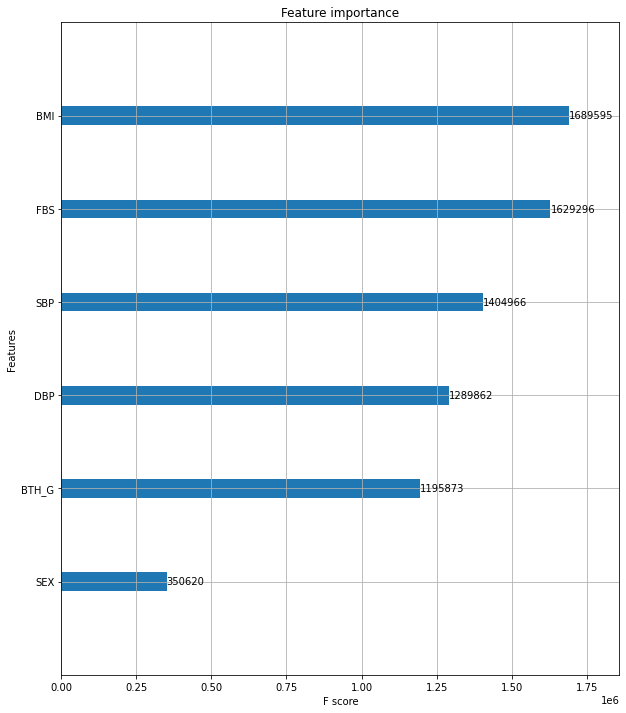

In [17]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax)

In [26]:
def get_clf_eval(y_test , pred):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    roc_auc = roc_auc_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
    
get_clf_eval(y_test, preds)

오차 행렬
[[142392  42362]
 [ 28428 157149]]
정확도: 0.8088, 정밀도: 0.7877, 재현율: 0.8468,    F1: 0.8162, AUC:0.8088


In [ ]:
# 다른 방식

# from xgboost import XGBClassifier

# xgb_wrapper = XGBClassifier(**params)

# # LightGBM도 XGBoost와 동일하게 조기 중단 수행 가능.
# evals = [(x_train, y_train), (x_test, y_test)]
# xgb_wrapper.fit(x_train, y_train, early_stopping_rounds=50, eval_metric="logloss", eval_set=evals, verbose=True)
# preds = xgb_wrapper.predict(x_test)
# pred_proba = xgb_wrapper.predict_proba(x_test)[:, 1]

In [54]:
# Training set score
y_pred_train = xgb_model.predict(dtrain)
print('LightGBM Model training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))
# Testing set score
accuracy = accuracy_score(xgb_pred, y_test)
print('LightGBM Model testing-set accuracy score: {0:0.4f}'.format(accuracy_score(y_test, _pred)))

LightGBM Model testing-set accuracy score: 0.8088


In [32]:
# view confusion-matrix
# Print the Confusion Matrix and slice it into four pieces

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, preds)
print('Confusion matrix\n\n', cm)
# print('\nTrue Positives(TP) = ', cm[0,0])
# print('\nTrue Negatives(TN) = ', cm[1,1])
# print('\nFalse Positives(FP) = ', cm[0,1])
# print('\nFalse Negatives(FN) = ', cm[1,0])


Confusion matrix

 [[142392  42362]
 [ 28428 157149]]


In [33]:
from sklearn.metrics import classification_report
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.83      0.77      0.80    184754
           1       0.79      0.85      0.82    185577

    accuracy                           0.81    370331
   macro avg       0.81      0.81      0.81    370331
weighted avg       0.81      0.81      0.81    370331



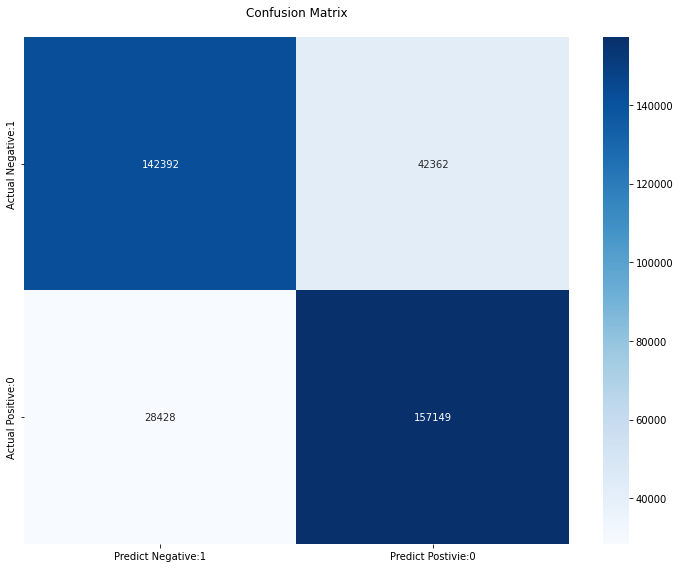

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,8))
cm = confusion_matrix(y_test, preds)
cm_matrix = pd.DataFrame(data=cm, columns=['Predict Negative:1', 'Predict Postivie:0'],
                                 index=['Actual Negative:1', 'Actual Positive:0'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix\n")
plt.tight_layout()

In [35]:
# Precision-Recall Curve Plot 그리기
def precision_recall_curve_plot(y_test, pred_proba):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba)
    
    # x축을 threshold, y축을 정밀도, 재현율로 그래프 그리기
    plt.figure(figsize=(8, 6))
    thresholds_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[:thresholds_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[:thresholds_boundary], linestyle=':', label='recall')
    
    # threshold의 값 X축의 scale을 0.1 단위로 변경
    stard, end = plt.xlim()
    plt.xticks(np.round(np.arange(stard, end, 0.1), 2))
    
    plt.xlim()
    plt.xlabel('thresholds')
    plt.ylabel('precision & recall value')
    plt.legend()
    plt.grid()

In [39]:
def algorithm_pipeline(x_train, x_test, y_train, y_test, 
                       model, param_grid, cv=10, scoring_fit='neg_mean_squared_error',
                       do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2
    )
    fitted_model = gs.fit(x_train, y_train)
    
    if do_probabilities:
      pred = fitted_model.predict_proba(x_test)
    else:
      pred = fitted_model.predict(x_test)
    
    return fitted_model, pred

In [43]:
predict_y = xgb_model.predict(dtest)


from sklearn.metrics import roc_curve
fprs, tprs, thresholds = roc_curve(y_test, predict_y)
thr_index = np.arange(1, thresholds.shape[0], 5)

print('샘플 추출을 위한 임곗값 배열의 index:', thr_index)
print('샘플 index로 추출한 임곗값: ', np.round(thresholds[thr_index], 2))

# 5 step 단위로 추출된 임계값에 따른 FPR, TPR 값
print('샘플 임곗값별 FPR: ', np.round(fprs[thr_index], 3))
print('샘플 임곗값별 TPR: ', np.round(tprs[thr_index], 3))

샘플 추출을 위한 임곗값 배열의 index: [    1     6    11 ... 94011 94016 94021]
샘플 index로 추출한 임곗값:  [1. 1. 1. ... 0. 0. 0.]
샘플 임곗값별 FPR:  [0.    0.001 0.001 ... 0.993 0.994 0.996]
샘플 임곗값별 TPR:  [0.005 0.016 0.021 ... 1.    1.    1.   ]


LightGBM 이 성능이 미세하게 우수함